In [7]:
import pywt
import numpy as np
import pandas as pa
import sqlite3, os
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt
import warnings
import ruptures as rpt
from scipy.signal import savgol_filter, medfilt
import numpy as np
import pylab as pl
from scipy.signal import hilbert
from scipy import signal

%matplotlib inline
warnings.filterwarnings("ignore")

DATA_PATH = "data"

In [13]:
ActualWeight = pa.read_excel("Seq2Seq/Actual_Weight_Urine_Stool_1736_1745.xlsx")
ActualWeight['Total Weight (g)'] = ActualWeight.iloc[:, 1:].sum(axis = 1)
ActualWeight

,ID,Actual Urine Weight (g),Actual Stool Weight (g),Total Weight (g)
0,1736,196.98,191.21,388.19
1,1737,199.95,208.36,408.31
2,1738,196.98,356.79,553.77
3,1739,197.10,318.63,515.73
4,1740,200.00,254.93,454.93
5,1741,200.50,330.66,531.16
6,1742,200.79,374.66,575.45
7,1743,197.14,431.00,628.14
8,1744,198.93,492.33,691.26
9,1745,198.47,305.82,504.29


# Defecation

In [8]:
def GetSensor(use_i,sensor_i):
    sql_s = "SELECT timestamp_ms, value FROM data WHERE data_capture_id={} AND sensor_id={}".format(use_i,sensor_i)
    conn = sqlite3.connect('data/toilet.db')
    cursor = conn.execute(sql_s)
    time_measurements = []
    distance_measurements = []
    for row in cursor:
        time_measurements.append(row[0])
        distance_measurements.append(row[1])
    #endfor
    data_t = (time_measurements,distance_measurements)
    return data_t
#enddef

def cleanSensors(sensor1_t_l,sensor1_y_l,sensor2_t_l,sensor2_y_l):

    # get min / max of time-series
    #sensor1_t_l = data_d[1][0]
    #sensor2_t_l = data_d[2][0]
    #sensor1_y_l = data_d[1][1]
    #sensor2_y_l = data_d[2][1]
    min_t = min(min(sensor1_t_l),min(sensor2_t_l))
    max_t = max(max(sensor1_t_l),max(sensor2_t_l))

    # setup partitions
    step_t = 500
    min_floor_t = int(np.floor(min_t/step_t)*step_t)
    max_ceil_t = int(np.ceil(max_t/step_t)*step_t)
    
    step1_d = {}
    step2_d = {}
    for i in range(min_floor_t,max_ceil_t+step_t,step_t):
        step1_d[i] = []
        step2_d[i] = []
    #endfor

    # step through both and assign values to each partition
    for i in range(len(sensor1_t_l)):
        interval_t = int(np.floor(sensor1_t_l[i]/step_t)*step_t)
        step1_d[interval_t].append(sensor1_y_l[i])
    #endfor
    for i in range(len(sensor2_t_l)):
        interval_t = int(np.floor(sensor2_t_l[i]/step_t)*step_t)
        step2_d[interval_t].append(sensor2_y_l[i])
    #endfor

    # step through each partition and either take averages or set to nan
    clean1_d = {}
    for i in step1_d.keys():
        if(len(step1_d[i]) > 0):
            clean1_d[i] = np.mean(step1_d[i])
    #endfor
    clean1_sz = pa.Series(clean1_d)

    clean2_d = {}
    for i in step2_d.keys():
        if(len(step2_d[i]) > 0):
            clean2_d[i] = np.mean(step2_d[i])
    #endfor
    clean2_sz = pa.Series(clean2_d)
    
    return clean1_sz, clean2_sz

def GetTotalWeight(data_capture_id):
    data_d = {}
    data_d[2] = GetSensor(data_capture_id, 2) # seat scale
    data_d[3] = GetSensor(data_capture_id, 3) # foot scale
    
    #t0 = data_d[2][0][0]
    
    clean1_sz, clean2_sz = cleanSensors(data_d[2][0],data_d[2][1],data_d[3][0],data_d[3][1])
    seatScale_sz = clean1_sz/1000
    footScale_sz = clean2_sz/1000
    sumScale_sz = seatScale_sz  + footScale_sz
    #sumScaleFiltered_sz = pd.Series(signal.medfilt(sumScale_sz, 11))
        
    sumScale_sz.index = (sumScale_sz.index - sumScale_sz.index[0])/1000
    #x_ix = sumScale_sz.index
    return sumScale_sz

def GetRadarSum(data_capture_id):

    data_fn = 'data/data_frames/data_capture_{}/radar_data.txt'.format(data_capture_id)
    data_f = open(data_fn,'rt')
    line_s = data_f.read()
    data_l = eval(line_s)

    # save array of images
    t0_sz = pa.Series(data_l[0]['data'])
    data_d = {}
    for j in range(len(data_l)):
        t = data_l[j]['timestamp_ms']
        j_sz = pa.Series(data_l[j]['data'][0])
        data_d[t] = j_sz
    #endfor
    data_df = pa.DataFrame(data_d)
    
    area_d = {}
    floor_i = 50
    ceil_i = 200
    for i in data_df.columns:
        sq_sz = (data_df[i])**2
        area_d[i] = sum(sq_sz.iloc[floor_i:ceil_i])
    #endfor
    area_sz = pa.Series(area_d)
    area_sz = area_sz / 1e9
    area_sz = area_sz - area_sz.median()
    t0 = data_l[0]['timestamp_ms']
    area_sz.index = (area_sz.index-t0)/1000 #
    
    return area_sz

In [9]:
def ApplyEnvelope(sz):
    analytic_signal = hilbert(sz)
    env_sz = pa.Series(np.abs(analytic_signal))
    env_sz.index = sz.index
    return env_sz

def GetValuesAboveThreshold(sz, threshold):
    return sz > threshold

def GetValuesBelowThreshold(sz, threshold):
    return sz < threshold

def ApplyMedianFilter(sz, window_size):
    filt_sz = pa.Series(signal.medfilt(sz, window_size))
    filt_sz.index = sz.index
    return filt_sz

def GetStartEndTimesOfBooleanSz(sz):
    ts = sz.index
    start_end_times = []
    
    i = 0
    while i < len(sz):
        if sz.values[i] == True:
            j = i
            while (j < len(sz)-1) and (sz.values[j+1] == True):
                j += 1
            start_end_times.append([ts[i], ts[j]])
            i = j + 1
        else:
            i += 1

    return start_end_times

def GetWeightChange(weight_sz, start_time, end_time):
    start_idx = (pa.Series(weight_sz.index) > start_time).idxmax() - 1
    end_idx = (pa.Series(weight_sz.index) > end_time).idxmax()
    #print("Weight at start time: {}".format(weight_sz.iloc[start_idx]))
    #print("Weight at end time: {}".format(weight_sz.iloc[end_idx]))
    return weight_sz.iloc[start_idx] - weight_sz.iloc[end_idx]

def GetWeightChangeMinMax(weight_sz, start_time, end_time):
    #start_idx = (pa.Series(weight_sz.index) > start_time).idxmax() - 1
    end_idx = (pa.Series(weight_sz.index) > end_time).idxmax()
    weight_sz_start_end = weight_sz[(weight_sz.index > start_time) & (weight_sz.index < end_time)]
    return max(weight_sz_start_end) - weight_sz.iloc[end_idx]

def RightExtendBooleanTrueValues(sz, extension_time):
    temp_sz = sz.copy()
    i = 1
    while i < len(temp_sz):
        if((temp_sz.values[i-1] == True) and (temp_sz.values[i] == False)):
            extension_end_time = temp_sz.index[i] + extension_time
            while (i < len(temp_sz)) and (temp_sz.index[i] < extension_end_time):
                temp_sz.values[i] = True
                i += 1
        i += 1
    return temp_sz

def LeftExtendBooleanTrueValues(sz, extension_time):
    temp_sz = sz.copy()
    i = len(temp_sz) - 2
    while i >= 0:
        if((temp_sz.values[i] == False) and (temp_sz.values[i+1] == True)):
            extension_end_time = temp_sz.index[i] - extension_time
            while (i >= 0) and (temp_sz.index[i] > extension_end_time):
                temp_sz.values[i] = True
                i -= 1
        i -= 1
    return temp_sz

In [10]:
def GetDefecationWeightLoss(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time):
    defecation_start_end_times = GetDefecationStartEndTimes(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time)
    defecation_weight_loss = 0
    
    total_weight_sz = GetTotalWeight(DATA_CAPTURE_ID)
    total_weight_filt_sz = ApplyMedianFilter(total_weight_sz, filter_window_size)
    
    for start_end in defecation_start_end_times:
        weight_loss = GetWeightChange(total_weight_filt_sz, start_end[0], start_end[1])
        if weight_loss > 0:
            defecation_weight_loss += weight_loss
            #print("Between {} and {}, weight loss:{}\n".format(start_end[0], start_end[1], weight_loss))
    return defecation_weight_loss

def GetDefecationStartEndTimes(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time):
    radar_sum_sz = GetRadarSum(DATA_CAPTURE_ID)
    radar_sum_env_sz = ApplyEnvelope(radar_sum_sz)
    radar_sum_env_filt_sz = ApplyMedianFilter(radar_sum_env_sz, filter_window_size)
    radar_sum_filt_sz = ApplyMedianFilter(radar_sum_sz, filter_window_size)
    radar_vals_above_threshold = GetValuesAboveThreshold(radar_sum_filt_sz, threshold)
    radar_vals_above_threshold = RightExtendBooleanTrueValues(radar_vals_above_threshold, extension_time)
    radar_vals_above_threshold = LeftExtendBooleanTrueValues(radar_vals_above_threshold, extension_time)
    defecation_start_end_times = GetStartEndTimesOfBooleanSz(radar_vals_above_threshold)
    
    return defecation_start_end_times

In [11]:
def PlotDefecationWeightRadar(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time):
    start_end_times = GetDefecationStartEndTimes(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time)
    
    total_weight_loss = GetDefecationWeightLoss(DATA_CAPTURE_ID, filter_window_size, threshold, extension_time)
    print("Predicted total: {}".format(total_weight_loss))
    if DATA_CAPTURE_ID in ActualWeight.ID:
        print("Actual    total: {}".format(ActualWeight[ActualWeight.ID == DATA_CAPTURE_ID].iloc[:, 2].values[0]/1000))
    
    radar_sum_sz = GetRadarSum(DATA_CAPTURE_ID)
    total_weight_sz = GetTotalWeight(DATA_CAPTURE_ID)
    total_weight_filt_sz = ApplyMedianFilter(total_weight_sz, 5)
    
    fig, ax = plt.subplots(3, 1, figsize = (10, 6))
    ax[0].plot(total_weight_sz)
    ax[1].plot(total_weight_filt_sz)
    ax[2].plot(radar_sum_sz)
    
    ax[0].set_ylim(total_weight_sz.median()-0.5, total_weight_sz.median()+0.5)
    ax[1].set_ylim(total_weight_sz.median()-0.5, total_weight_sz.median()+0.5)
    
    for i in range(3):
        for start_end_time in start_end_times:
            ax[i].axvspan(start_end_time[0], start_end_time[1], alpha=0.5, color='orange')
    
    plt.show()

Predicted total: 0.07450000000000045


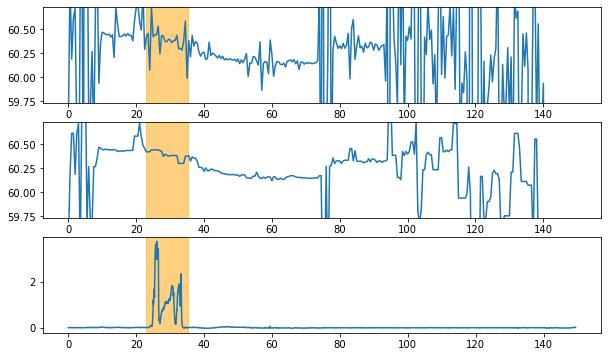

In [15]:
PlotDefecationWeightRadar(1763, 5, .15, 1.83)

Predicted total: 0.18549999999999045


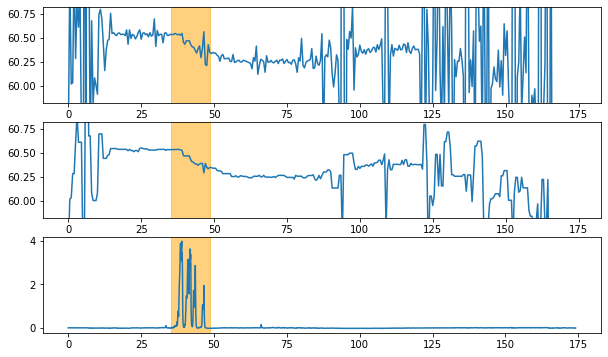

In [16]:
PlotDefecationWeightRadar(1767, 5, .15, 1.83)

# Area under Radar vs Defecation Weight

In [52]:
from scipy.integrate import simps, trapz
from scipy.stats.stats import pearsonr

In [39]:
def GetAreaUnderRadar(DATA_CAPTURE_ID):
    radar_sum_sz = GetRadarSum(DATA_CAPTURE_ID)
    x = np.array(radar_sum_sz.index)
    f = radar_sum_sz.values
    
    return simps(f, x), trapz(f, x)

In [40]:
data_captures = np.arange(1736, 1746)
actual_defecate_weights = []
area_under_radar = []

for DATA_CAPTURE_ID in data_captures:
    row = ActualWeight[ActualWeight.ID == DATA_CAPTURE_ID]
    actual_defecate_weights.append(row.iloc[:, 2].values[0] / 1000)
    area_under_radar.append(GetAreaUnderRadar(DATA_CAPTURE_ID))

In [47]:
area_under_radar = np.array(area_under_radar)
actual_defecate_weights = np.array(actual_defecate_weights)

In [66]:
data_captures[further]

array([1740, 1737, 1736])

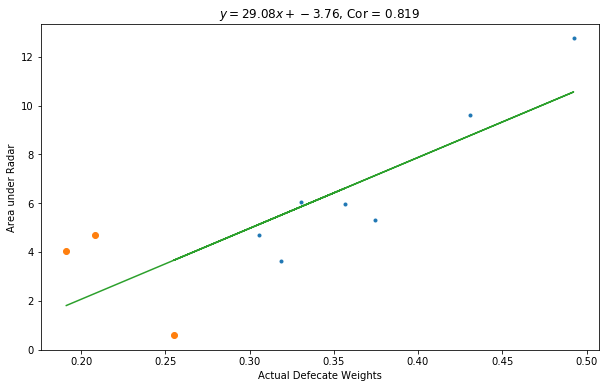

In [76]:
x, y = actual_defecate_weights, area_under_radar[:, 1]
m, b = np.polyfit(x, y, 1)
yhat = m * x + b
further = np.abs(yhat - y).argsort()[-3:][::-1]
corr = pearsonr(x, y)

plt.figure(figsize = (10, 6))
plt.plot(x, y, '.')
plt.plot(x[further], y[further], 'o')
plt.plot(x, m * x + b)
plt.xlabel("Actual Defecate Weights")
plt.ylabel("Area under Radar")
plt.title("$y = {:.2f}x + {:.2f}$, Cor = {:.3f}".format(m, b, corr[0]));